In [1]:
from qiskit import *
from qiskit.visualization import array_to_latex, plot_histogram, plot_state_city
from qiskit.extensions import UnitaryGate
from qiskit.tools.monitor import job_monitor
from ipycanvas import *
import matplotlib.pyplot as plt
import numpy as np

# Procedurally generating maps using quantum computers
## Abstract

Procedural generation is one of the many applications of quantum computing. In this notebook, we will be focusing on showing how procedural generation of maps can be achieved on quantum computers two different methods. The first method is inspired by the Sudoku and grover's algorithm, while the other is inspired by the classical example algorithm *wavefunction collapse*. We show that these algorithms correctly generate maps based on a ruleset. 

## Introduction
The map our algorithms will generate is made up of tiles. The basis for our algorithms are adjacency rules. These rules dictate what kind of tiles can be placed next to one another. The first algorithm even allows these rules to be extended to control different aspects of the outcome. In our case we have 4 tiles numbered 0 through 3 that have the following adjacency rules:

| Tile # | Possible neighbours |
|--------|---------------------|
| 0      | 1                   |
| 1      | 0,2                 |
| 2      | 1,3                 |
| 3      | 2                   |

This leads us to the following adjacency rules in code:

In [2]:
adjacency_rules = [[0,0], [1,1], [2,2], [3,3], [1,2], [0,1], [2,3]]

Every pair of numbers of lists, means that these two types of tiles can be placed next to one another.

We define also the height and the width of our map:

In [3]:
WIDTH = 2
HEIGHT = 2

We propose two algorithms for procedural map generation:

The first one, simpler in nature, treats the map and the adjacency rules like a sudoku game. It is easy to implement and understand and gives a lot of freedom with new rules, but uses a lot of qubits and the amount of iterations needs to be approximated.

The second algorithm is more closely related to the classical *wavefunction collapse* algorithm. We start of with a uniform superposition of all states and collapse a single tile. We then use grover's algorithm to "*filter*" out neighbours that wouldn't work according to the adjacency rules. The algorithm currently only works on a map of one dimension, because of implementation problems that will be discussed later.

## Constructing the framework for our algorithms

We define a couple of functions to aid us in handling the data we get from the later defined algorithms.

Because the results we get from the circuit are in the form of a bitstring, we define a function that converts the bitstring into a twodimensional array representing our map: 

In [4]:
def bitstring_to_map(bitstring):
    # split up the bistring into two bits each and reverse it because of qiskit's little endian convention
    bitstring  = bitstring.replace(" ", "")
    split_bitstring = np.array_split(np.array(list(bitstring)), WIDTH*HEIGHT)[::-1] 
    map = [[None for _ in range(WIDTH)]for _ in range(HEIGHT)][:] # Initialize empty map
    for i, tile in enumerate(split_bitstring): # Iterate through the list of bits and set the appropriate tile
        map[i//WIDTH][i%WIDTH] = int("".join(tile), 2)
    return map

We define a function to check if a given map is valid:

In [5]:
def check_map(map):
    for y in range(HEIGHT): 
        for x in range(WIDTH): # iterate through each tile
            # collect the neighbours on the bottom and left of that tile
            neighbours = []
            if y < HEIGHT-1:
                neighbours.append(map[y+1][x])
            if x < WIDTH-1:
                neighbours.append(map[y][x+1])
            # Go through each neighbour and check the validity of the ordering according to our adjacency rules
            for neighbour in neighbours:
                found = False
                for rule in adjacency_rules:
                    rule.sort()
                    pair = [map[y][x], neighbour]
                    pair.sort()
                    if rule == pair:
                        found = True
                        break
                if not found:
                    return False
    return True

We create a function to visualize the map and draw it directly into the jupyter notebook:

In [6]:
colors = ["blue", "yellow", "green", "brown", "black", "black", "black", "black", "black", "black"]

def render_map(map):
    canvas = Canvas(width=WIDTH*100, height=HEIGHT*100) # Initialize the canvas
    # Iterate through each tile on the map and draw the according rectangle on the canvas
    for y, row in enumerate(map):
        for x, tile in enumerate(row): 
            canvas.fill_style = colors[map[y][x]]
            canvas.fill_rect(x*100, y*100, 100)
    return canvas

render_map([
    [1,2],
    [2,2]
])

Canvas(height=200, width=200)

## First algorithm: Grover's algorithm
### Building the circuit
Our first algorithm is an implementation of grover's algorithm. [2]

We use 2 qubits for each tile, so we can easily calculate the number of qubits:

In [7]:
n_qubits = WIDTH*HEIGHT*2

Because we perform grover's algorithm, we have to find an oracle $U_\omega$ and a diffuser $U_s$. 

The diffuser is straightforward. The diffuser has to apply the transformation $2|s\rangle\langle s| - \mathbb I$. As our state starts of as a uniform superposition of all possible configurations (valid and non-valid), we first have to apply the transformation $H ^{\otimes n}$:
$$H^{\otimes n} |s\rangle = |0\rangle^{\otimes n}$$
Now we apply the transformation $X^{\otimes n } MCZ X ^{\otimes n}$, which applies a phase of $-1$ to the state:
$$X^{\otimes n } MCZ X ^{\otimes n} |0\rangle ^{\otimes n} = -|0\rangle ^{\otimes n}$$
Now we again apply $n$ Hadamards, to bring us to our final state. 

Therefore, our diffuser looks like this: $$U_S = H^{\otimes n} X^{\otimes n } MCZ X ^{\otimes n}H^{\otimes n}$$

This function applies this diffuser to the circuit:

In [8]:
def apply_diffuser(qc):
    diffuser = QuantumCircuit(n_qubits)
    diffuser.h(list(range(n_qubits)))
    
    # Turn |00..0> into |11..1>
    diffuser.x(list(range(n_qubits)))
    # way to perform multicontrolled-z in qiskit
    diffuser.h(n_qubits-1)
    diffuser.mct(list(range(n_qubits-1)), n_qubits-1)
    diffuser.h(n_qubits-1)
    # Turn -|11..1> back into -|00..0>
    diffuser.x(list(range(n_qubits)))
    
    diffuser.h(list(range(n_qubits)))
    gate = diffuser.to_gate()
    gate.name = "$U_s$"
    qc.append(gate, list(range(n_qubits)))

Now we have to define an oracle. Because we don't know what the final outcome looks like, we can't just define a unitary matrix. We have to achieve the effect of applying a phase of $-1$, when all of the rules are fulfilled.

As a tile can interact with all of its neighbours, we encounter the problem of applying a negative phase multiple times, effectively making the correct solutions indistinguishable from the incorrect ones, if we would just check pairs of qubits and their relationship. One could define a circuit that corrects these effects, but that would involve knowing which of the solutions are correct, which we don't know.

An effective solution is proposed by the classic example of using grover's algorithm to solve sudoku. [1] Ancilla qubits are used to check the conditions to solve the puzzle. We do the same: For any two neighbouring tiles, we apply an oracle that applies an X to an ancilla qubit initialized in state $|0\rangle$, if the relationship between these two tiles is valid. This can be done using some toffolis and Xs:

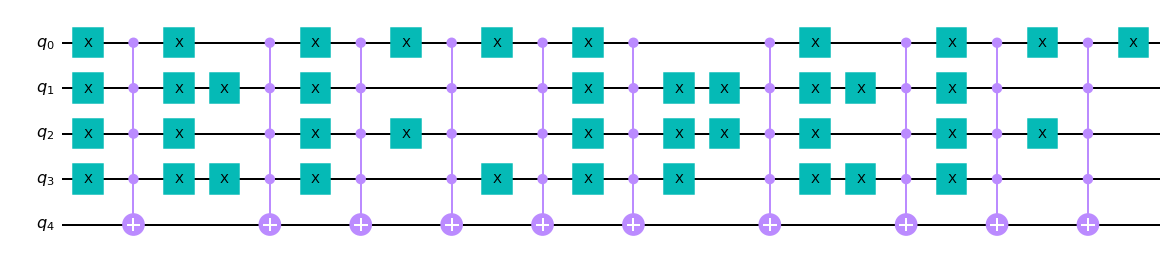

In [9]:
def get_oracle():
    gate = QuantumCircuit(5)
    for rule in adjacency_rules:
        a = bin(rule[0])[2:].zfill(2)
        b = bin(rule[1])[2:].zfill(2)
        for i, bit in enumerate(list(a+b)[::-1]):
            if not bool(int(bit)): gate.x(i)
        gate.mct(list(range(4)), 4)
        for i, bit in enumerate(list(a+b)[::-1]):
            if not bool(int(bit)): gate.x(i)
        if a+b == b+a: 
            continue
        for i, bit in enumerate(list(b+a)[::-1]):
            if not bool(int(bit)): gate.x(i)
        gate.mct(list(range(4)), 4)
        for i, bit in enumerate(list(b+a)[::-1]):
            if not bool(int(bit)): gate.x(i)
    gate.draw()
    return gate

get_oracle().draw()

We define a function to turn this circuit into a gate and apply it to the qubits corresponding to a specific tile.

In [10]:
def circuit_to_gate(qc, name):
    qc = qc.to_gate()
    qc.name = name
    return qc

def check(qc, tile1, tile2, ancilla):
    qc.append(circuit_to_gate(get_oracle(), "$U_O$"), [2*tile1, 2*tile1 +1, 2*tile2, 2*tile2+1, ancilla])

We define a function to apply the checks to all the tiles. We use the oracle defined above to check between any two neighbouring tiles: 

In [11]:
def check_circuit(qc, ancillas):
    ancilla = 0
    for y in range(HEIGHT):
        for x in range(WIDTH):
            if y +1 < HEIGHT:
                t0 = y * HEIGHT + x
                t1 = (y+1) * HEIGHT + x
                check(qc, t0, t1, ancillas[ancilla])
                ancilla += 1
            if x + 1 < WIDTH:
                t0 = y * HEIGHT + x
                t1 = y * HEIGHT + x + 1
                check(qc, t0, t1, ancillas[ancilla])
                ancilla += 1

We can use the ancilla qubits to apply a phase of $-1$ to the circuit by doing a multi-controlled-$X$ controlled on the ancillas and targeted on a qubit initialized in the state $|-\rangle$. If all ancilla qubits are $|1\rangle$, which happens when every checking_oracle performed an $X$, the multi-controlled-$X$ performs an $X$ on the qubit initialized at $|-\rangle$, which in turn applies a phase of $-1$ to the system using the phase-kickback-effect.

After that we uncompute the checking to undo the entanglement between the qubits representing the tiles and the ancilla qubits:

In [12]:
def apply_oracle(qc, ancillas, minus_register):
    check_circuit(qc, ancillas)
    qc.mct(ancillas, minus_register)
    check_circuit(qc, ancillas)

We put everything together: We initialize the different registers and build a circuit:

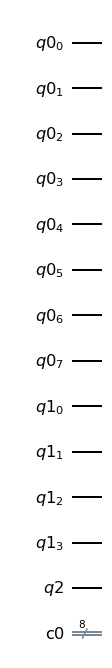

In [13]:
tiles = QuantumRegister(n_qubits)
result = ClassicalRegister(n_qubits)
ancillas = QuantumRegister((WIDTH-1)*HEIGHT + (HEIGHT-1)*WIDTH)
minus_register = QuantumRegister(1)

qc = QuantumCircuit(tiles, ancillas, minus_register, result) 

qc.draw()

We initialize the tiles into a superposition of all configurations and put the last qubit into the $|-\rangle$-state:

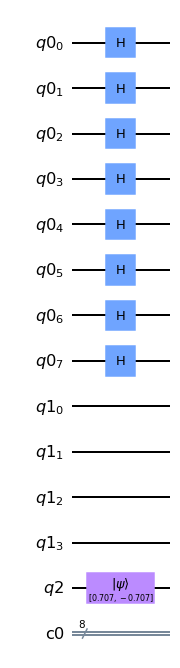

In [14]:
qc.h(list(range(n_qubits))) # Put the circuit into a superposition of all maps (valid and non-valid ones)

 # Put minus register into the |-> state to use the phase kickback effect
qc.initialize([1, -1]/np.sqrt(2), minus_register)
qc.draw()

Now we apply the oracle and then the diffuser (one iteration of grover's algorithm) $r$ times. $r$ can be determined by using the following formula: $r = \lfloor{\frac \pi 4 \sqrt{\frac N K}}\rfloor$, where $k$ needs to be approximated. 

In the case of the map being $2\times2$ with $10$ rules, $r=1$ seems to work reasonably well.

In [15]:
for i in range(1): # Apply Grover's algorithm 
    apply_oracle(qc, ancillas, minus_register)
    apply_diffuser(qc)

We measure the results into the corresponding register:

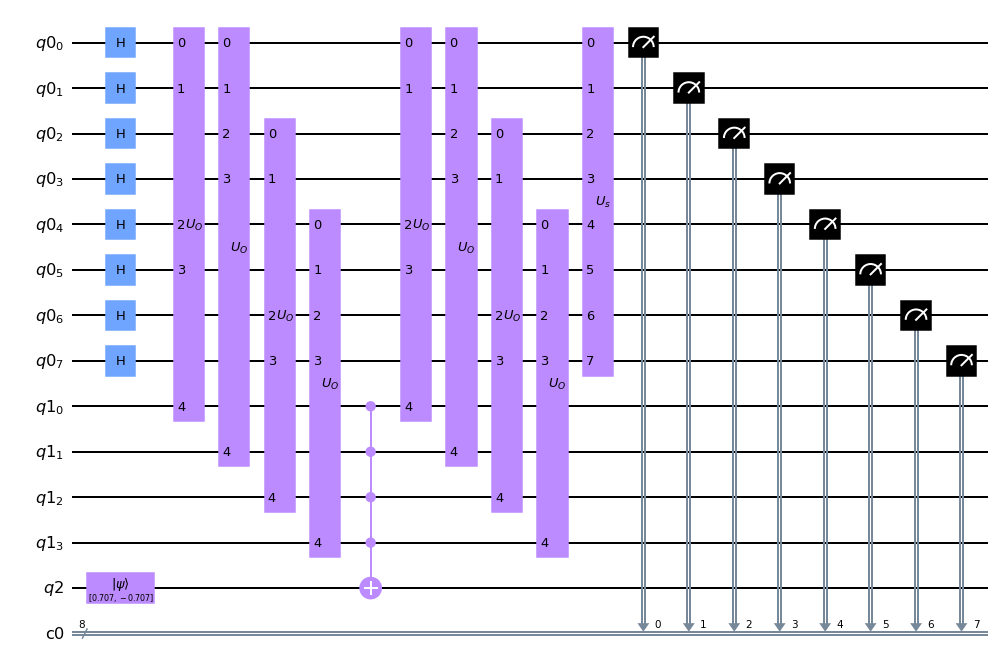

In [16]:
qc.measure(tiles, result) # Measure the resulting map
qc.draw() # Draw the circuit

### Running the circuit on simulators

We can use IBMs cloud simulators to simulate our circuits on and render the resulting map using the function defined above:

In [18]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('simulator_mps')
job = execute(qc,backend = device,shots = 5000)
job_monitor(job)
results = job.result()
counts = results.get_counts(qc)
results = sorted(counts.items(), key=lambda x:-x[1])

ibmqfactory.load_account:WARNING:2022-06-08 20:07:11,060: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


### Analyzing the results

Using the results, we draw the resulting map and the graph showing the different results (green means correct, red means incorrect). We also extract the percentage of correct results:

Probability of getting a correct solution:  0.98


Canvas(height=200, width=200)

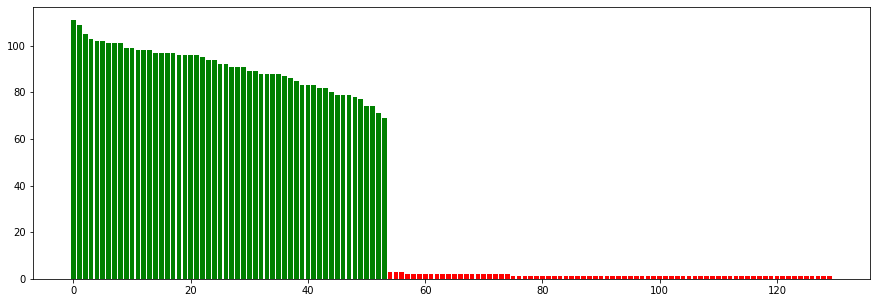

In [19]:
fig = plt.figure(figsize = (15, 5))
total, total_correct = 0, 0
for i, map in enumerate(results):
    correct = check_map(bitstring_to_map(map[0]))
    plt.bar(i, map[1], color ='green' if correct else 'red')
    total += map[1]
    if correct: total_correct += map[1]

print("Probability of getting a correct solution: ", total_correct/total )

render_map(bitstring_to_map(results[0][0]))

The results we get look really promising: about 98% of the measurements result in a correct map. We can also see that there is a sharp drop-off between the correct and incorrect results. This means that this might be a good way to procedurally generate maps maps, according to the usecase.

The downside to this method is the amount of qubits it uses. For a map with $T$ types of tiles and of size $N\times M$, $\log_2\left( T\right)\cdot N\cdot M + (N-1)(M-1)$ qubits are required. 

The biggest upside to this method is being able to quickly define new rules (like that there can be a maximum number of tiles of a specific type in the map). 

______________________

## Second algorithm: "Quantum *Wavefunction Collapse*"
### Understanding the circuit

The second algorithm has more resemblances with the classical algorithm *wavefunction collapse*. It works by collapsing the qubits representing a tile by measuring them and then applying grover's algorithm with the appropriate oracle, which is determined by the result of the measurement and the allowed neighbours according to the ruleset, to the qubits representing neighbouring qubits.

When the neighbouring cell only has a single neighbour, this is really simple. One can iterate through every possible celltype and create a oracle and grover's algorithm according to the allowed neighbours of that type. This is then applied to that qubit and controlled on if the measurement of the neighbouring cell was of that type.

When the cell has two neighbours, problems occur: The problem stems from the fact that one can't just apply the above suggested twice, as the diffuser assumes that $|s\rangle = H^{\otimes n} |0\rangle$, but due to the first grover's algorithm $|s\rangle$ is the result of the first grover's algorithm. Calculating the number of iterations required for the second grover's algorithm would require knowing the result of the first one.  

What could technically be done to solve this problem, is looking at all combinations of the two types of tiles of the neighbours and constructing an oracle for the overlap of both types in the ruleset, which would then be controlled on if the two types matched the measurements of the two neighbours. Unfortunately this isn't currently possible in qiskit, because of the OpenQASM 2.0 specification, therefore, this algorithm currently only works in one dimension.

The number of qubits has to be set to more than $2$. This is because when the amount of correct solutions is $k$ is greater or equal than half of the possibilities $n$ ($k\geq\frac n2$), the oracle for these $k$ correct solutions only differs from the oracle amplifying the incorrect solution by a global phase of $-1$. This would produce the opposite from the wanted effect. In this case, the number of qubits per tile has been set to $3$. To fix the types of tiles in the range we defined before (0 through to 3), we fix the third qubit to state $|0\rangle$.
Another solution to this problem has been proposed by Ahmed Younes et al. [3].

### Building the circuit
First, we define the width, the height and the amount of qubits: 

In [29]:
qubits_per_tile = 3
WIDTH = 4
HEIGHT = 1
n_qubits = WIDTH*HEIGHT*qubits_per_tile

We define the necessary registers (one quantum for the tiles and one classical for every tile) and construct the circuit. We need a separate ClassicalRegister for every tile, because we can only do classical controls on whole registers.

In [30]:
tiles = QuantumRegister(n_qubits)
results = [ClassicalRegister(qubits_per_tile) for _ in range(WIDTH*HEIGHT)]
qc = QuantumCircuit(tiles)
for register in results:
    qc.add_register(register)

We define a function to return a diffuser, which is defined in the same way as in the first algorithm:

In [31]:
def get_diffuser():
    diffuser = QuantumCircuit(qubits_per_tile)
    diffuser.h(list(range(qubits_per_tile)))
    
    # Turn |00..0> into |11..1>
    diffuser.x(list(range(qubits_per_tile)))
    # way to perform multicontrolled-z in qiskit
    diffuser.h(qubits_per_tile-1)
    diffuser.mct(list(range(qubits_per_tile-1)), qubits_per_tile-1)
    diffuser.h(qubits_per_tile-1)
    # Turn -|11..1> back into -|00..0>
    diffuser.x(list(range(qubits_per_tile)))
    
    diffuser.h(list(range(qubits_per_tile)))
    gate = diffuser.to_gate()
    gate.name = "$U_s$"
    return gate

We define a function that takes in a tile type and returns a gate performing grover's algorithm, that "filters out" the allowed neighbours. 
First we define an oracle that applies a phase of $-1$ to all valid neighbours for that tile type.
We exit early if there are no allowed neighbours. Finally we apply the oracle and the diffuser r times, where $$r = \left\lfloor \frac \pi 4 \sqrt{\frac N K}\right\rfloor$$

In [32]:
  def get_grover(neighbour):
    matrix = np.identity(2**qubits_per_tile)
    for rule in adjacency_rules:
        if neighbour in rule:
            if rule[0] == neighbour:
                matrix[rule[1]][rule[1]] = -1
            else:
                matrix[rule[0]][rule[0]] = -1
    oracle = UnitaryGate(matrix)
    diffuser = get_diffuser()
    k = sum(x == -1 for row in matrix for x in row )
    if k == 0:
        return None
    r = max(1, int(np.pi/4 * np.sqrt(2**2 / k)))
    grover = QuantumCircuit(qubits_per_tile)
    for i in range(r):
        grover.append(oracle, list(range(qubits_per_tile)))
        grover.append(diffuser, list(range(qubits_per_tile)))
    grover = grover.to_gate()
    grover.name = f"$G^{neighbour}_\omega$"
    return grover

We define a "filter" function that takes in the tile to be filtered and the neighbour controlling this operation.
The function goes through each possible tile type of the neighbour and applies the corresponding grover algorithm, if the measurement on the neighbour resultet in that tile type:

In [33]:
def filter(qc, tile, neighbour):
    for i in range(2**qubits_per_tile):
        grover = get_grover(i)
        if not grover == None:
            qc.append(grover, [qubits_per_tile*tile, qubits_per_tile*tile+1, 
                               qubits_per_tile*tile+2]).c_if(results[neighbour], i)

We define a function that measures a tile into the corresponding register:

In [34]:
def measure_tile(qc, tile):
    qc.measure([qubits_per_tile*tile, qubits_per_tile*tile+1, qubits_per_tile*tile+2], results[tile])

The final circuit is constructed by measuring the first tile. Then only the valid neighbours are filtered out and measuring the second tile is measured. This is repeated for every tile in our one-dimensional map. 

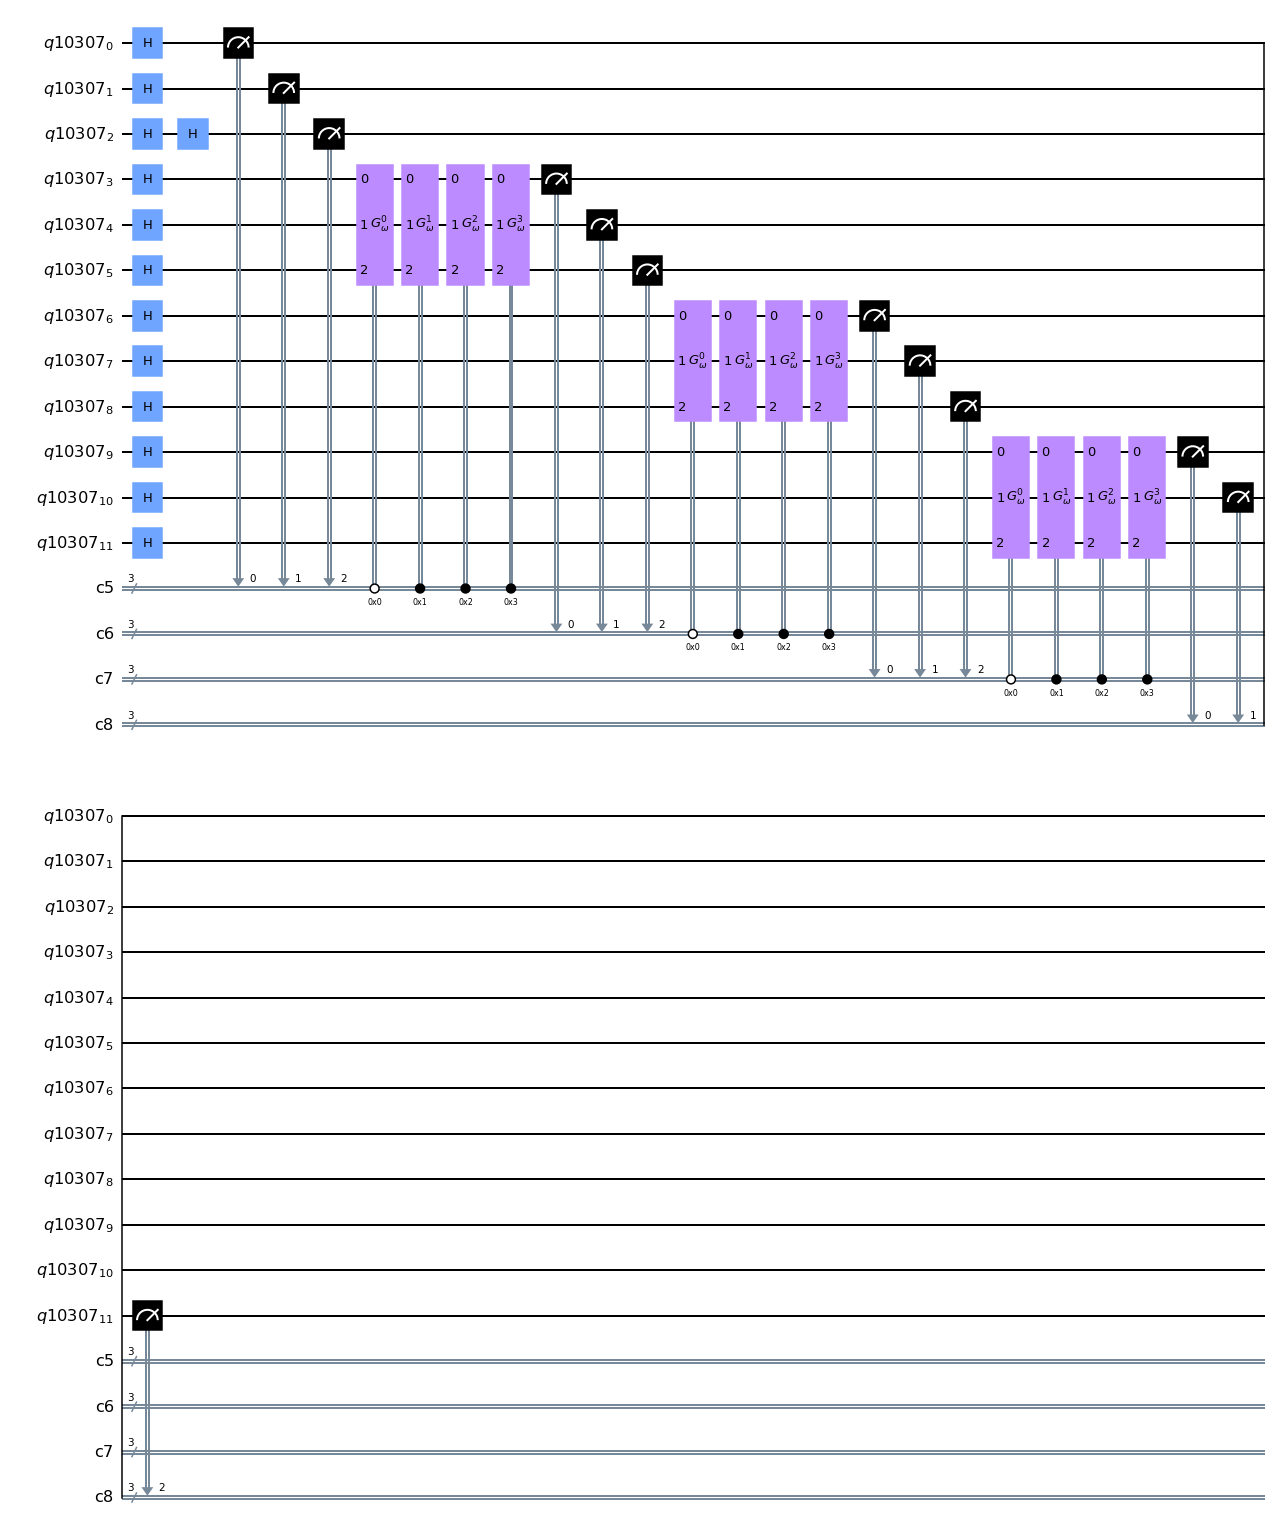

In [35]:
qc.h(list(range(n_qubits)))
qc.h([2]) # fix tile 0 at type 0, so that board wont go out of allowed range (type 0-3)
measure_tile(qc, 0)
for i in range(1, WIDTH):
    filter(qc, i, i-1)
    measure_tile(qc, i)
qc.draw()

### Running the circuit on simulators in the cloud
We run the circuit on IBM's cloud simulators:

In [36]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('simulator_mps')
job = execute(qc,backend = device,shots = 10000, optimization_level=3)
job_monitor(job)
results = job.result()
counts = results.get_counts(qc)

ibmqfactory.load_account:WARNING:2022-06-08 20:12:19,161: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


### Analyzing the results

Probability of getting a correct solution:  0.7672


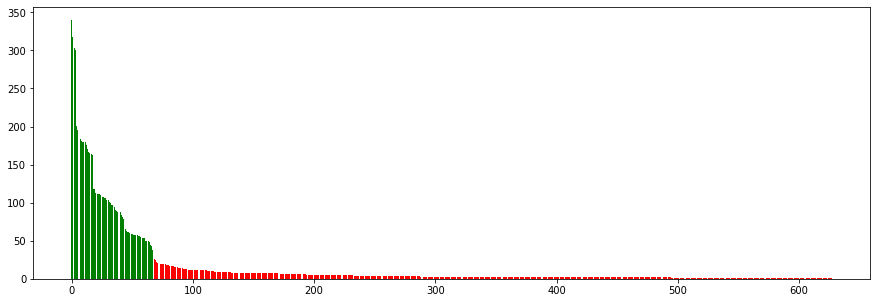

In [37]:
results= sorted(counts.items(), key=lambda x:-x[1])
fig = plt.figure(figsize = (15, 5))
total, total_correct = 0, 0
for i, map in enumerate(results):
    correct = check_map(bitstring_to_map(map[0]))
    plt.bar(i, map[1], color ='green' if correct else 'red')
    total += map[1]
    if correct: total_correct += map[1]

print("Probability of getting a correct solution: ", total_correct/total )

Using this algorithm, we get the probability of about 75% of getting a correct result. This isn't as good as the first algorithm, but this could be increased by choosing a better number of iterations, by choosing a multiple of $r$ that is closer to a natural number.

The biggest upside of the algorithm is that it uses a lot less qubits than the first algorithm. This still doesn't make it viable for near-term devices, for reasons that will be discussed.

Apart from the fact that this algorithm can currently only generate maps in one dimension, one must also take into account the fact that currently there are no devices that can run hybrid classical-quantum circuits, like the one proposed here. Support for hybrid is set to increase.

Another downside of this algorithm at its current stage is the fact that one cannot, like in the first algorithm, simply add rules that are different from just adjacency rules. 

Also the algorithm doesnt't have an equal distribution of correct solutions, which means that some solutions are more likely than others.

## Conclusion

In this notebook we have presented two algorithms that are able to generate maps based on a set of adjecency rules regarding the arrangement of tiles. We have shown that these algorithms generate these maps with high probability. 

Both algorithms suffer from difficulties in the implementation: The first one can't be run on publicly available real devices due to a lack of qubits, while the other one can only generate one dimensional maps, because currently there is no way to control an operation on two classical registers. Both of these issues will be resolved as the technology matures.

Because these algorithms can't be run on the same devices as their usecases, like games and ecosystem simulations, I don't see any uses for end-users for on-device procedural generation in the near term. The research can be pursued, if there is interest for it.

The course and the final project have thaught me a lot and have allowed me to build an excellent foundation for my future challenges in quantum computing.

### References:

[1] ANIS, MD SAJID, Abby-Mitchell, Héctor Abraham, AduOffei, Rochisha Agarwal, Gabriele Agliardi, Merav Aharoni, et al. 2021. “Qiskit: An Open-Source Framework for Quantum Computing.” https://doi.org/10.5281/zenodo.2573505

[2] Grover, Lov K. 1996. “A Fast Quantum Mechanical Algorithm for Database Search.” arXiv. <https://doi.org/10.48550/ARXIV.QUANT-PH/9605043>.

[3] Younes, Ahmed, Jon Rowe, and Julian Miller. 2003. “A Hybrid Quantum Search Engine: A Fast Quantum Algorithm for Multiple Matches.” <https://doi.org/10.48550/ARXIV.QUANT-PH/0311171>.

[4] Gumin, Maxim. 2016. “Wave Function Collapse Algorithm.” <https://github.com/mxgmn/WaveFunctionCollapse>.

[5] Singleton, Robert L, Michael L Rogers, and David L Ostby. 2021. “Grover’s Algorithm with Diffusion and Amplitude Steering.” arXiv. <https://doi.org/10.48550/ARXIV.2110.11163>.


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table